# Image Processing (Part1)
Tasks:
- contrast stretching
- linear filtering
- α-Blending
- unsharp masking
- thresholding
- isodata threshold

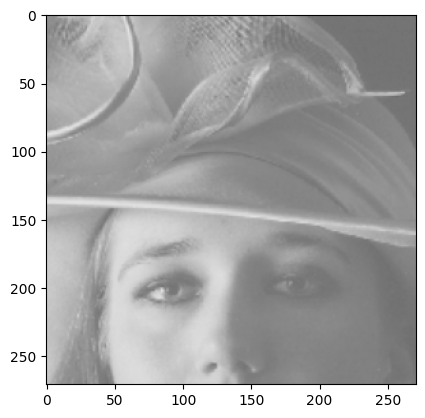

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
img = cv2.imread('data\person1.png')
plt.imshow(img)

In [33]:
def plot_histogram(img):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(img)
    ax.set_title('Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    #hist = cv2.calcHist([img],[0],None,[256],[0,256])
    #ax.plot(hist)
    ax.hist(img.ravel(),256,[0,256])
    ax.set_title('Histogram')

In [46]:
np.max(img)

229

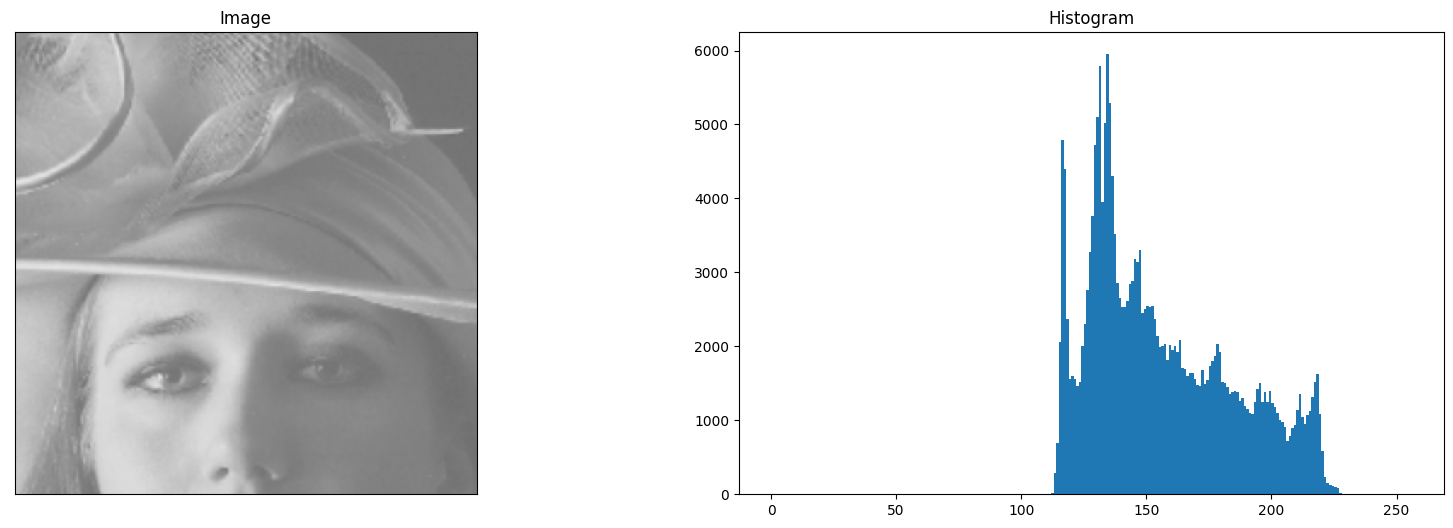

In [34]:
plot_histogram(img)

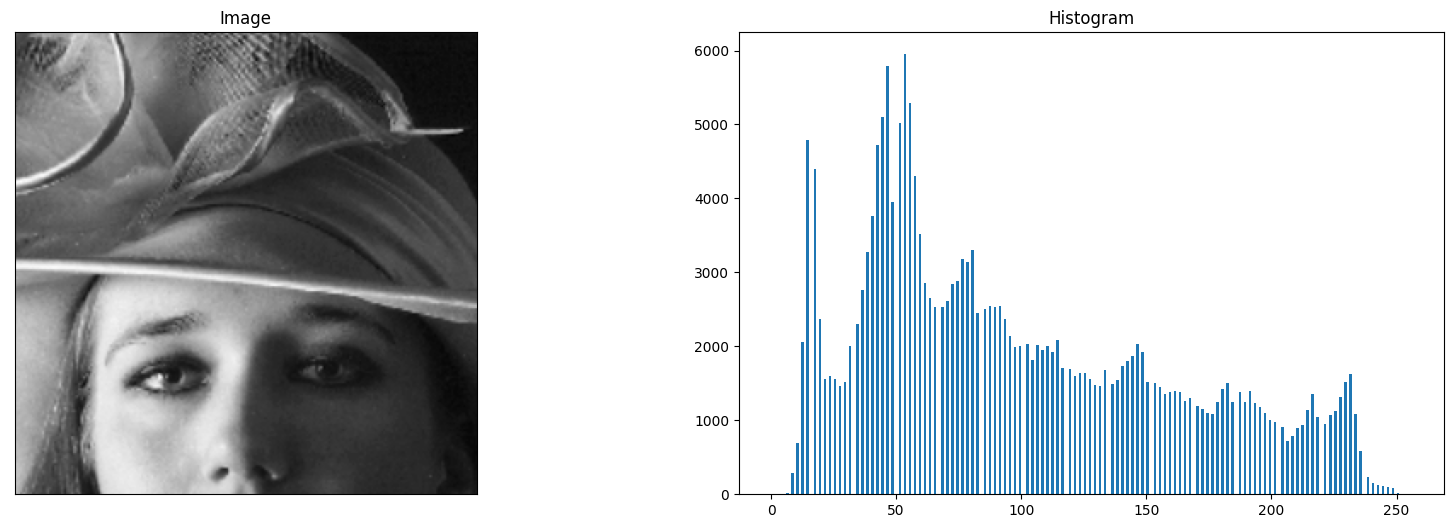

In [54]:
def contrast_stretch(img, min_val=0, max_val=255):
    min_pixel = np.min(img)
    max_pixel = np.max(img)

    a = (max_val - min_val) / (max_pixel - min_pixel)
    b = min_val - a * min_pixel

    stretched_img = np.clip(a * img + b, 0, 255).astype(np.uint8)
    return stretched_img

img_cst = contrast_stretch(img)
plot_histogram(img_cst)

# Limitations
Explain why contrast stretching of a digital image cannot always lead to satisfactory results when the original image was very very dark (or very very light).

Answer: If the whole image covers the whole range, contrast stretching does nothing

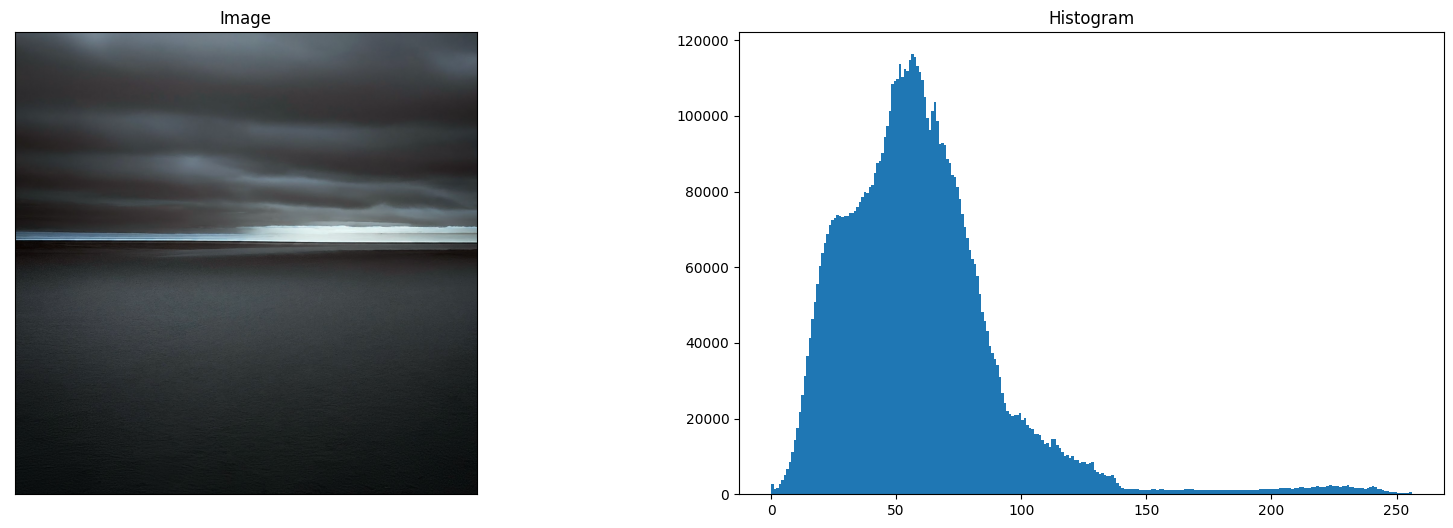

In [67]:
img = cv2.imread('data\dark_image.jpg')
plot_histogram(img)

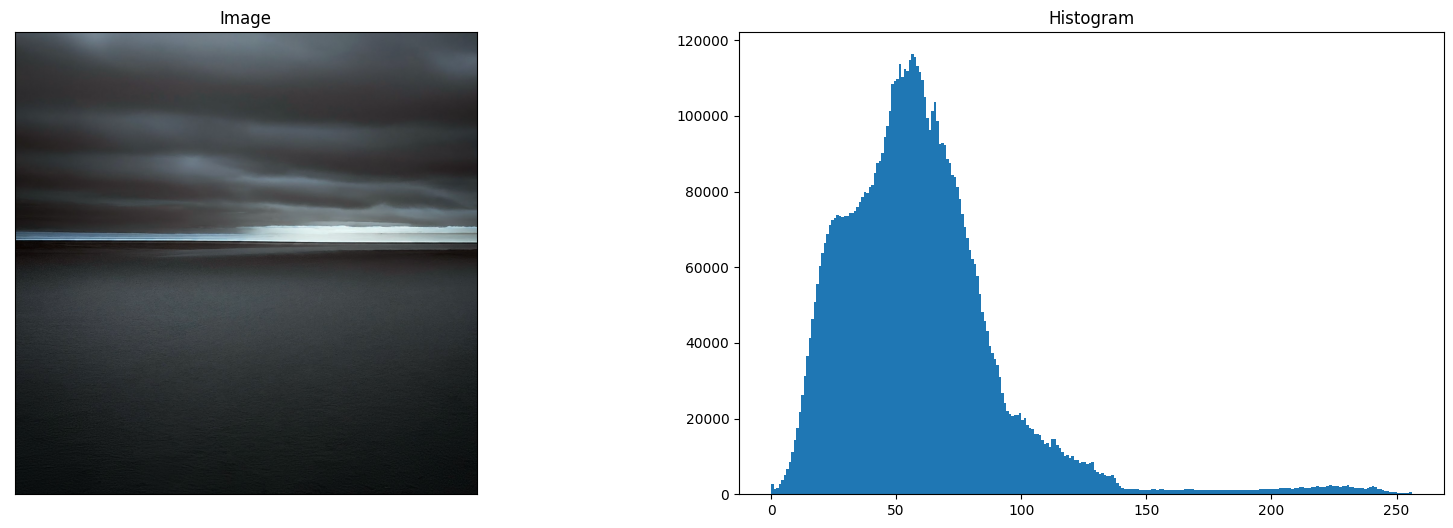

In [68]:
img_cst = contrast_stretch(img)
plot_histogram(img_cst)

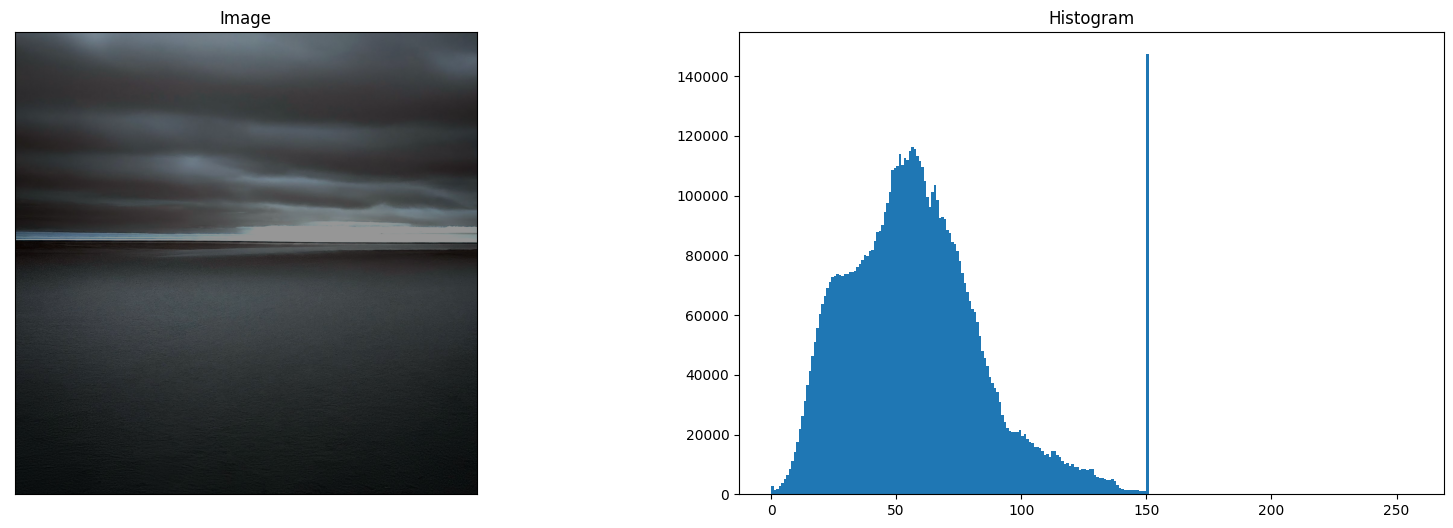

In [81]:
img1 = np.clip(img, 0, 150).astype(np.uint8)
plot_histogram(img1)

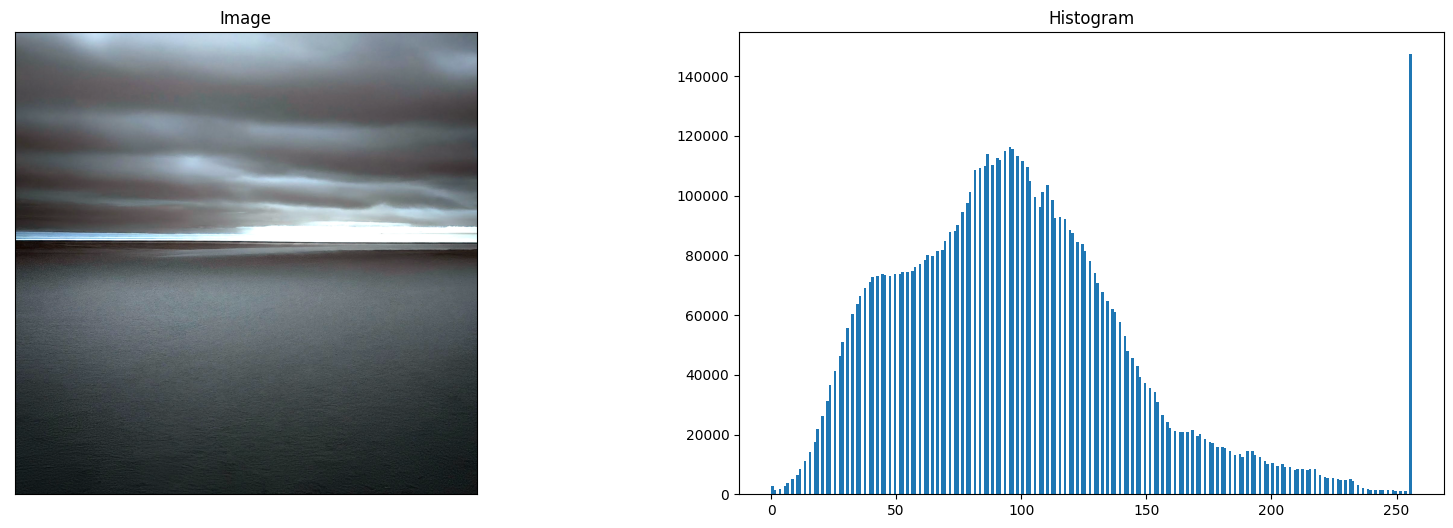

In [82]:
img_cst = contrast_stretch(img1)
plot_histogram(img_cst)

# Application to colorful image
Let’s first change the color model from RGB to HSV. And then stretch the contrast in the V image and use the new V values together with the original H and S values. Implement this contrast stretching algorithm. Why is this contrast stretching method leading to reasonable results?

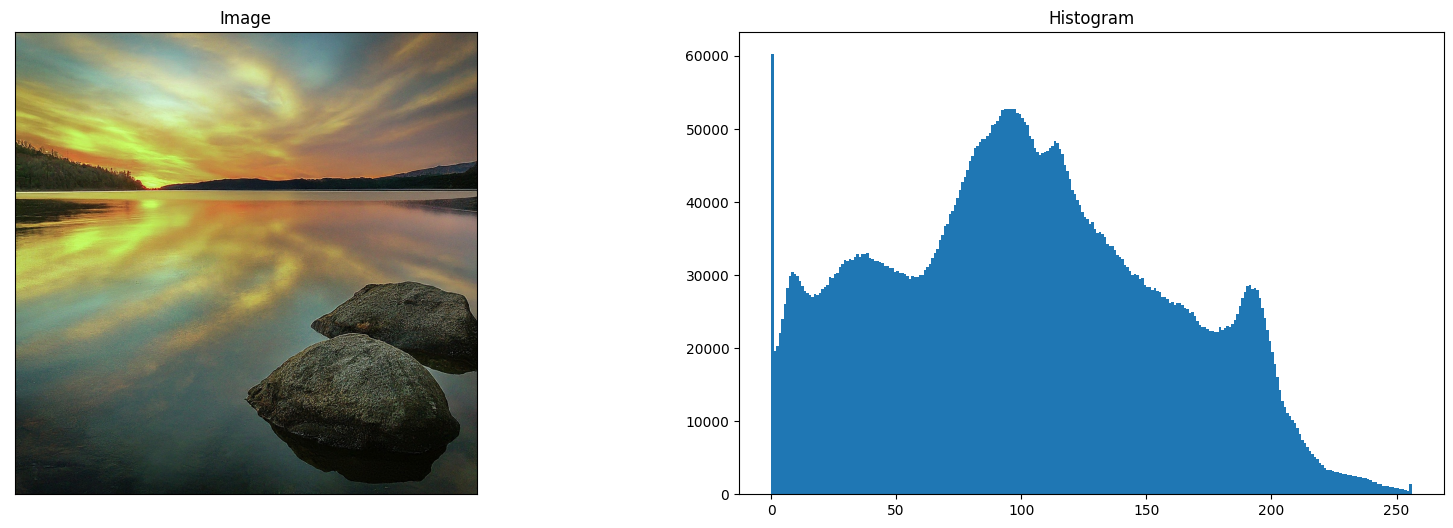

In [87]:
def contrast_stretch_hsv(img, clip_limit=0.05):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v_min, v_max = np.percentile(v, [clip_limit * 100, (1 - clip_limit) * 100])
    v_stretched = np.clip((v - v_min) / (v_max - v_min) * 255, 0, 255).astype(np.uint8)
    hsv = cv2.merge([h, s, v_stretched])
    img_contrast_stretched = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img_contrast_stretched

# Example usage:
img = cv2.imread('data\light_image.jpg')
bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plot_histogram(bgr_img)

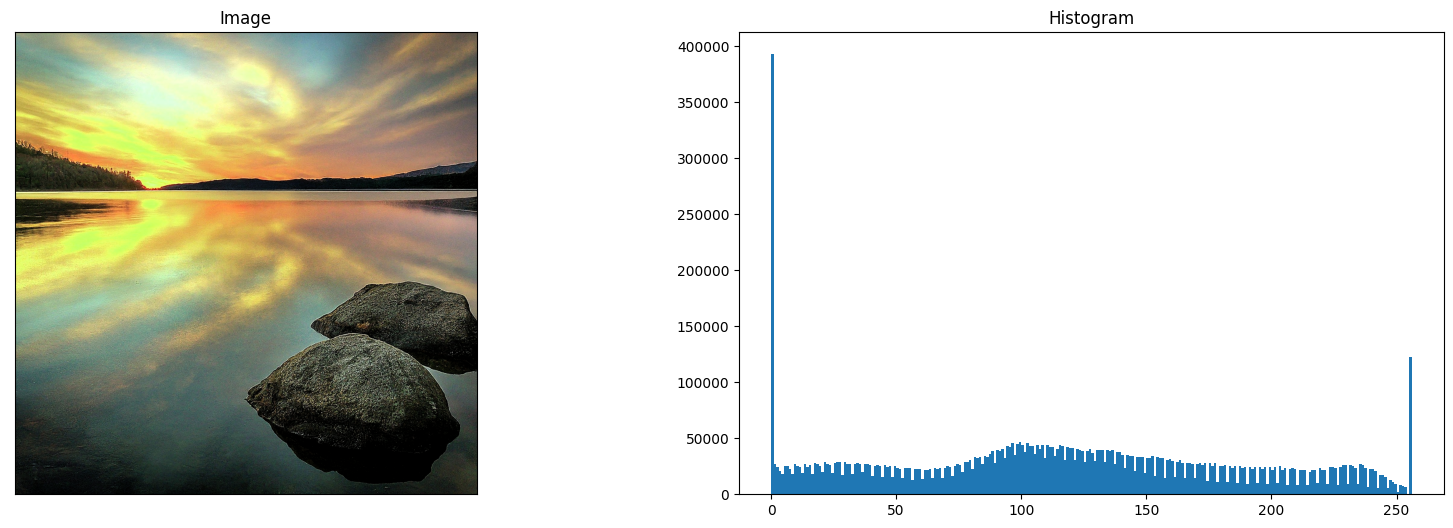

In [89]:
img_contrast_stretched = contrast_stretch_hsv(img)
bgr_img = cv2.cvtColor(img_contrast_stretched, cv2.COLOR_RGB2BGR)
plot_histogram(bgr_img)

# Linear filtering

In [139]:
def linfilter(f, w):
    g = np.empty(f.shape, dtype=f.dtype)  # the resulting image
    M,N = f.shape
    K,L = (np.array(w.shape)-1)//2
    
    def value(i,j):
        """The function returning the value f[i,j] in case
        (i,j) in an index 'in the image', otherwise it return 0"""
        if i<0 or i>=M or j<0 or j>=N:
            return 0
        return f[i,j]
    for j in range(N):
        for i in range(M):
            summed = 0
            for k in range(-K,K+1):
                for l in range(-L,L+1):
                    summed += value(i+k,j+l) * w[k+K,l+L]
            g[i,j] = summed
    return g

In [174]:
def linfilter2(f, w):
    """Linear Correlation based on neigborhood processing without loops"""
    g = np.empty(f.shape, dtype=f.dtype)  # the resulting image
    M,N = f.shape
    K,L = (np.array(w.shape)-1)//2

    for j in range(N):
        for i in range(M):
            ii = np.minimum(M-1, np.maximum(0, np.arange(i-K, i+K+1)))
            jj = np.minimum(N-1, np.maximum(0, np.arange(j-L, j+L+1)))
            nbh = f[np.ix_(ii,jj)]
            g[i,j] = (nbh * w).sum()
    return g

In [250]:
def linfilter3(f, w):
    """Linear Correlation using Translates of Images"""
    M,N = f.shape
    K,L = (np.array(w.shape)-1)//2
    
    di,dj = np.meshgrid(np.arange(-L,L+1), np.arange(-K,K+1))
    didjw = zip(di.flatten(), dj.flatten(), w.flatten())
    
    def translate(di,dj):
        ii = np.minimum(M-1, np.maximum(0, di+np.arange(M)))
        jj = np.minimum(N-1, np.maximum(0, dj+np.arange(N)))
        return f[np.ix_(ii, jj)]
    
    r = 0*f;
    for di, dj, weight in didjw:
        #r = np.add(r, weight * translate(di,dj))
        r += (weight * translate(di,dj)).astype(np.uint8)
    return r

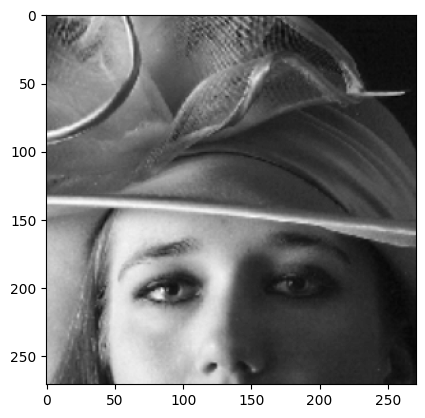

In [252]:
img = cv2.imread('data\person1.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

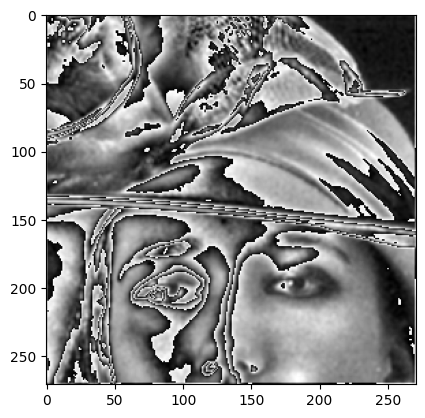

In [253]:
size = 3
kernel = np.ones((size, size)) / size * size
img3 = linfilter(img, kernel)
plt.imshow(img3, cmap='gray')

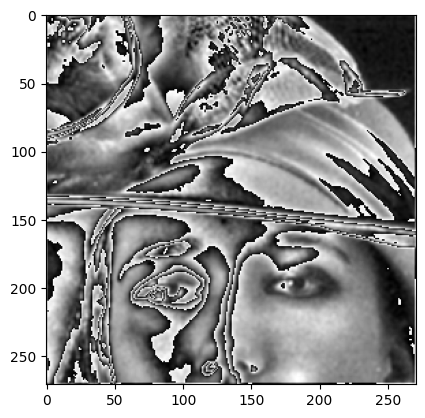

In [256]:
img3_2 = linfilter2(img, kernel)
plt.imshow(img3, cmap='gray')

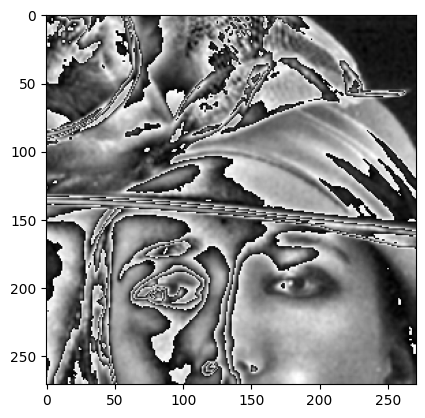

In [257]:
img3_3 = linfilter3(img, kernel)
plt.imshow(img3_3, cmap='gray')

In [266]:
import time
def get_time(img, size, lin_func):
    """Calculate excution time"""
    kernel = np.ones((size, size)) / size * size

    start = time.time()
    _ = lin_func(img, kernel)

    return round(time.time() - start, 5)
def get_all_times(lin_func):
    times = []
    for size in range(3, 12, 2):
        t = get_time(img, size, lin_func)
        times.append(t)
    return times

t1 = get_all_times(linfilter)
t2 = get_all_times(linfilter2)
t3 = get_all_times(linfilter3)

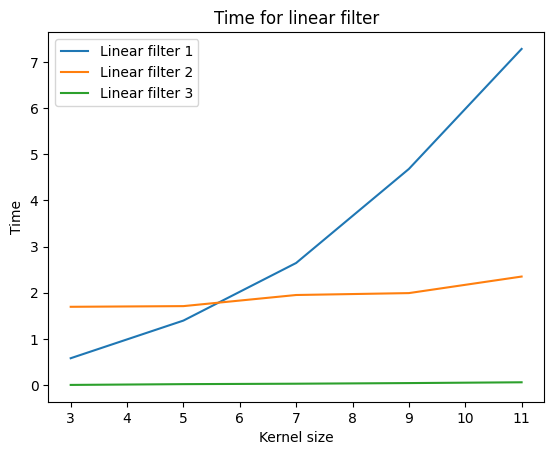

In [268]:
# Sample data
x = range(3, 12, 2)

# Create the plot
plt.plot(x, t1, label='Linear filter 1')
plt.plot(x, t2, label='Linear filter 2')
plt.plot(x, t3, label='Linear filter 3')

# Add labels, title, and legend
plt.xlabel('Kernel size')
plt.ylabel('Time')
plt.title('Time for linear filter')
plt.legend()

# Show the plot
plt.show()

In [270]:
print(t1, t2, t3)

[0.57883, 1.39522, 2.64394, 4.68246, 7.28471] [1.69373, 1.70852, 1.94957, 1.99079, 2.34961] [0.0, 0.01688, 0.02636, 0.04004, 0.05709]


# Image blending

In [288]:
img = cv2.imread('data\person1.png', cv2.IMREAD_GRAYSCALE)

In [367]:
def plot_unsharp_masking(img, beta, cmap='gray'):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(img, cmap=cmap)
    ax.set_title('Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    blur = cv2.blur(img, (5,5))
    ax.imshow(blur, cmap=cmap)
    ax.set_title('Blurred')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[2]
    res = img + beta * (img - blur)
    ax.imshow(res, cmap=cmap)
    ax.set_title('Original + Beta * (Original - Blurred)')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def plot_unsharp_masking_color(img, beta):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title('Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    blur = unsharp_masking_color(img)
    ax.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
    ax.set_title('Blurred')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[2]
    res = (img + beta * (img - blur)).astype('uint8')
    ax.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    ax.set_title('Original + Beta * (Original - Blurred)')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def unsharp_masking_color(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v_blurred = cv2.blur(v, (5,5))
    hsv = cv2.merge([h, s, v_blurred])
    img_blur = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img_blur.astype('uint8')

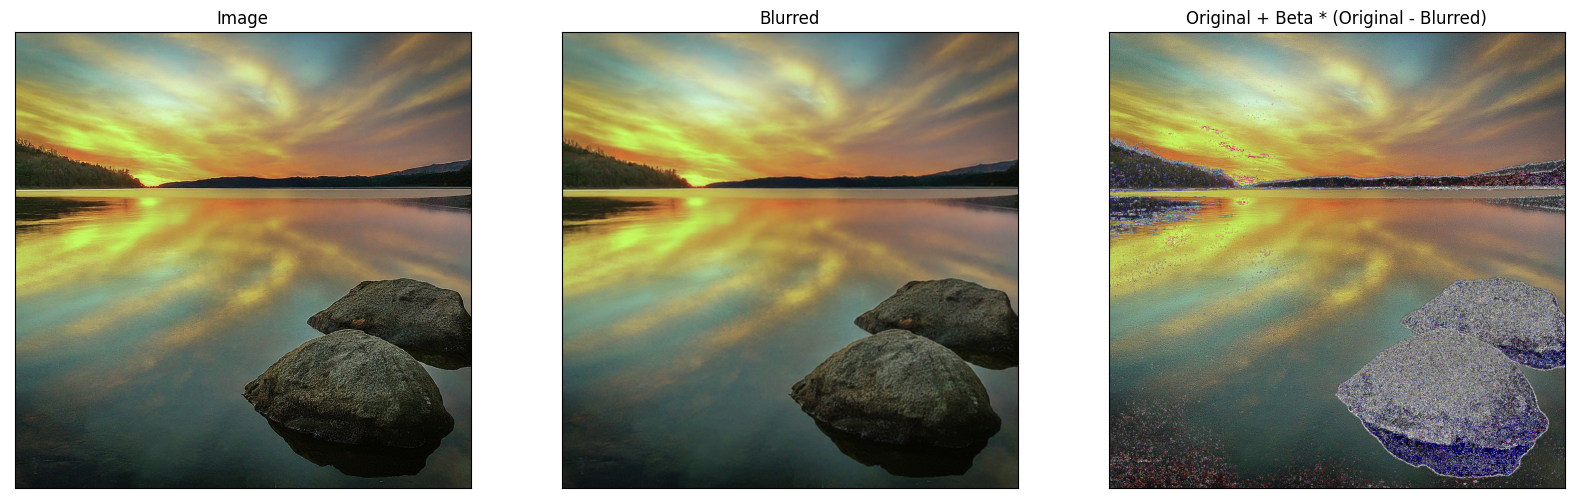

In [368]:
plot_unsharp_masking(img, 2)

In [369]:
img1 = cv2.imread('data\light_image.jpg')
img2 = cv2.imread('data\dots.png')

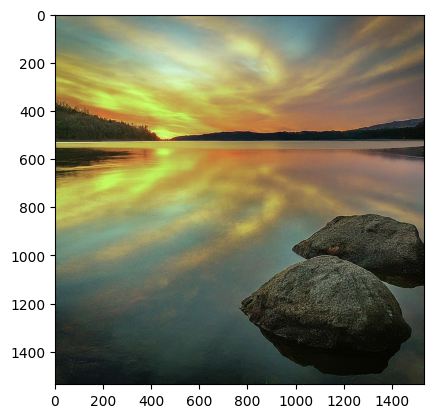

In [370]:
img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(1536, 1536, 3)


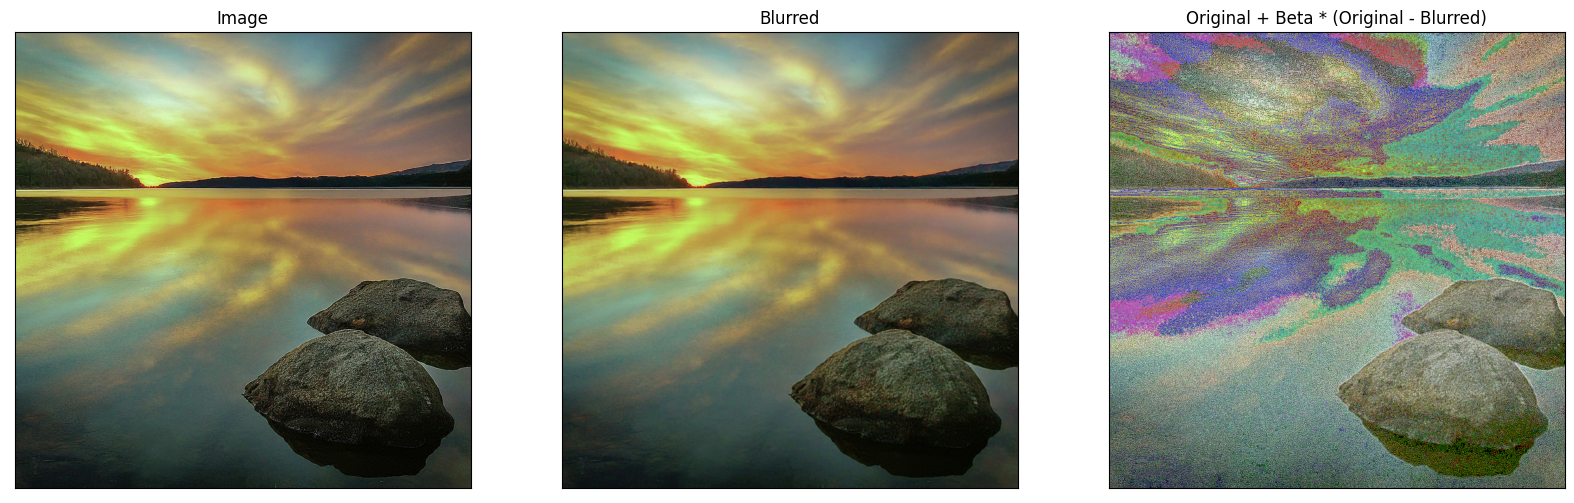

In [371]:
plot_unsharp_masking_color(img1, 0.5)

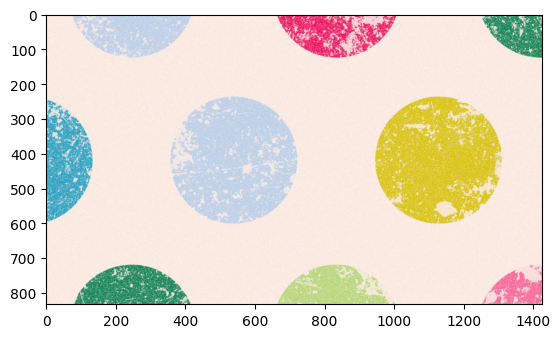

In [325]:
img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [326]:
img1.shape

(1536, 1536, 3)

In [327]:
img2.shape

(833, 1426, 3)

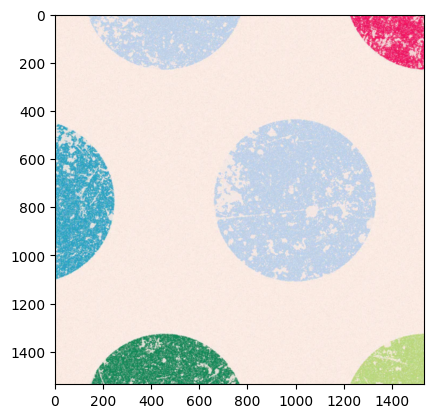

In [332]:
def scale_to_height(img, desired_height):
    height, width = img.shape[:2]
    scale_factor = desired_height / height
    new_width = int(width * scale_factor)
    dim = (new_width, desired_height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized
img = scale_to_height(img2, img1.shape[0])
img = img[:, :img1.shape[1], :]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

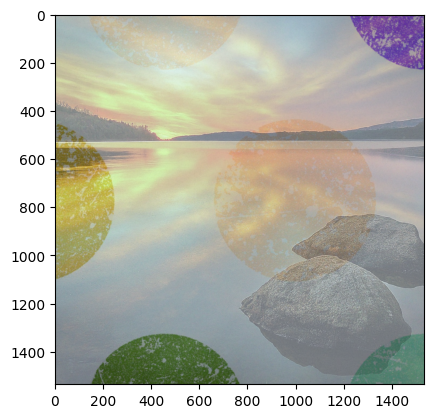

In [343]:
def alpha_blending(f, g, alpha):
    return ((1 - alpha) * f + alpha * g).astype(np.uint8)

res = alpha_blending(img1, img, 0.5)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)

# Histogram Equalizer

In [378]:
def plot_images(img1, img2, with_histogram = True, cmap = 'gray'):
    fig, axs = plt.subplots(1 + with_histogram, 2, figsize=(20, 6))
    if with_histogram:
        ax = axs[0, 0]
    else:
        ax = axs[0]
    ax.imshow(img1, cmap=cmap)
    ax.set_title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if with_histogram:
        ax = axs[1, 0]
    else:
        ax = axs[1]
    ax.imshow(img2, cmap=cmap)
    ax.set_title('Result')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if with_histogram:
        ax = axs[0, 1]
        ax.hist(img1.ravel(),256,[0,256])
        ax = axs[1, 1]
        ax.hist(img2.ravel(),256,[0,256])

In [382]:
img = cv2.imread('data\person1.png', cv2.IMREAD_GRAYSCALE)
equalized_img = cv2.equalizeHist(img)

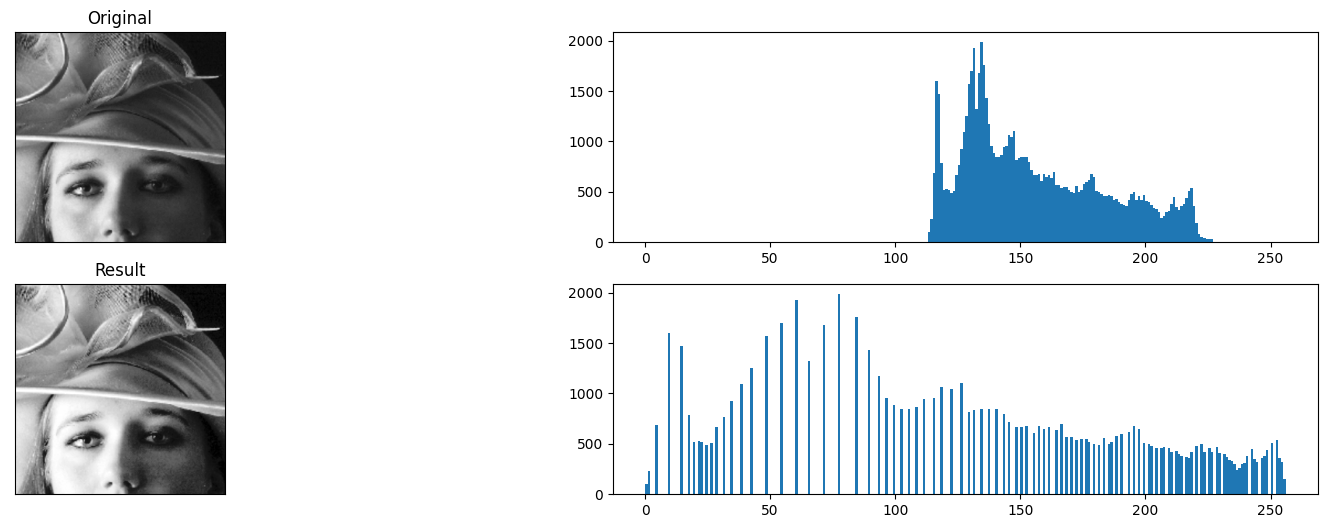

In [383]:
plot_images(img, equalized_img)

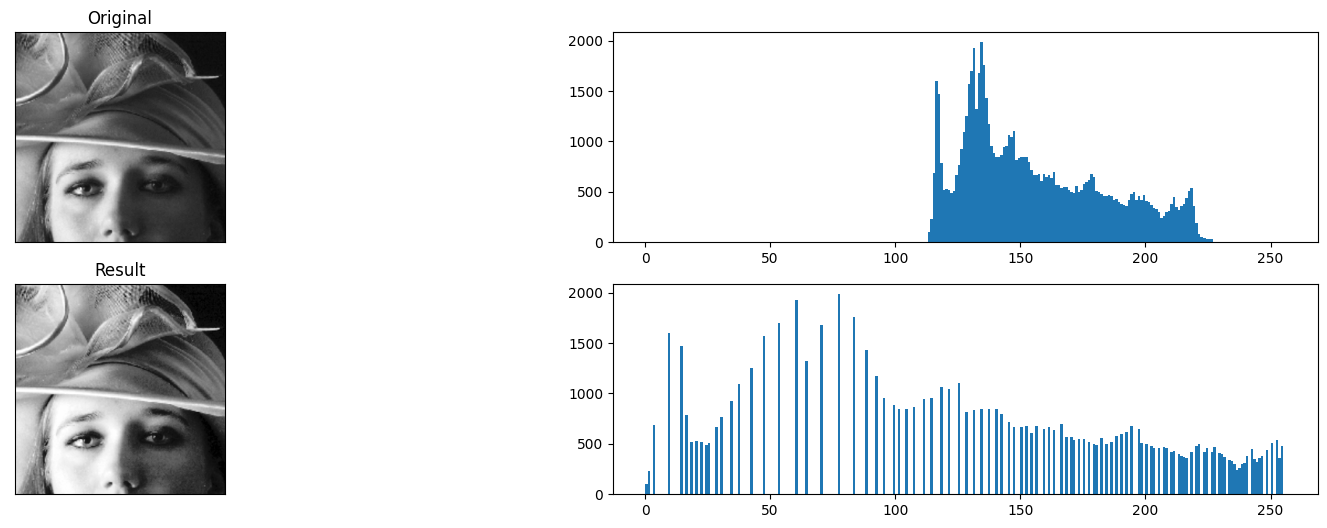

In [405]:
def histogram_equalization(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf = cdf.astype('uint8')
    img_equalized = cdf[img]

    return img_equalized
img = cv2.imread('data\person1.png', cv2.IMREAD_GRAYSCALE)
equalized_img = histogram_equalization(img)
plot_images(img, equalized_img)

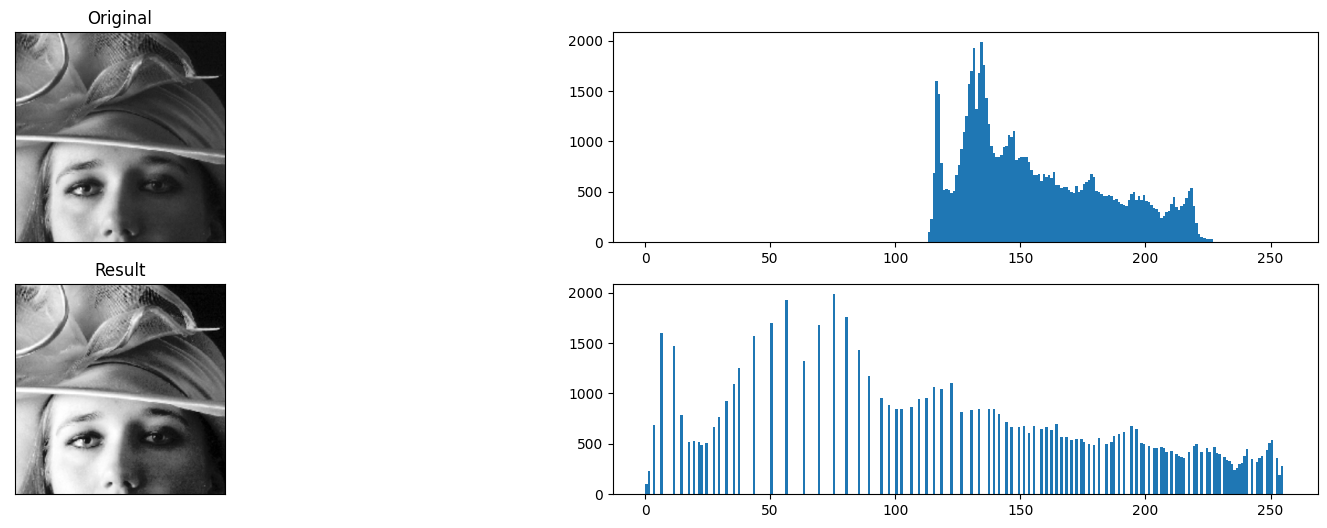

In [406]:
def histogramEqualization(f, bins=100):
    his, be = np.histogram(f, range=(0,256), bins=bins)
    his = his.astype(float)/sum(his)
    return np.interp(f, be, np.hstack((np.zeros((1)), np.cumsum(his)))) * 255

img = cv2.imread('data\person1.png', cv2.IMREAD_GRAYSCALE)
equalized_img = histogramEqualization(img)
plot_images(img, equalized_img)

# Isodata Threshold

In [518]:
def plot_histogram(im, cmap='gray'):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(img, cmap=cmap)
    ax.set_title('Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    #hist = cv2.calcHist([img],[0],None,[256],[0,256])
    #ax.plot(hist)
    ax.hist(img.ravel(),256,[0,256])
    ax.set_title('Histogram')
    
def isodata_threshold(f, t, eps = 0.0001):
    f = f / 255
    while 1:
        mL = np.nan_to_num(np.mean(f[f <= t]), nan=0)
        mH = np.nan_to_num(np.mean(f[f > t]), nan=0)
        t_new = (mL+mH)/2
        if abs(t-t_new) < eps:
            break
        t = t_new
        print(t)
    return t

def isodata_threshold_2(f, t, eps = 0.0001):
    f = f / 255
    hist, bin_edges = np.histogram(f, bins=256, range=(0, 1))
    while 1:
        idx = np.where(bin_edges < t)[0].max()
        mL = np.nan_to_num(np.sum(hist[:idx] * bin_edges[1:idx+1]) / np.sum(hist[:idx]) , nan=0)
        mH = np.nan_to_num(np.sum(hist[idx:] * bin_edges[idx+1:]) / np.sum(hist[idx:]) , nan=0)
        t_new = (mL+mH)/2
        if abs(t-t_new) < 255 * eps:
            break
        t = t_new
        print(t)
    return t

In [546]:
img = cv2.imread('data\dots1.png', cv2.IMREAD_GRAYSCALE)
isodata_threshold_2(img, 0.2) * 255

0.34996422003157474
0.44667070258572505
0.4755603870431433


121.26789869600154

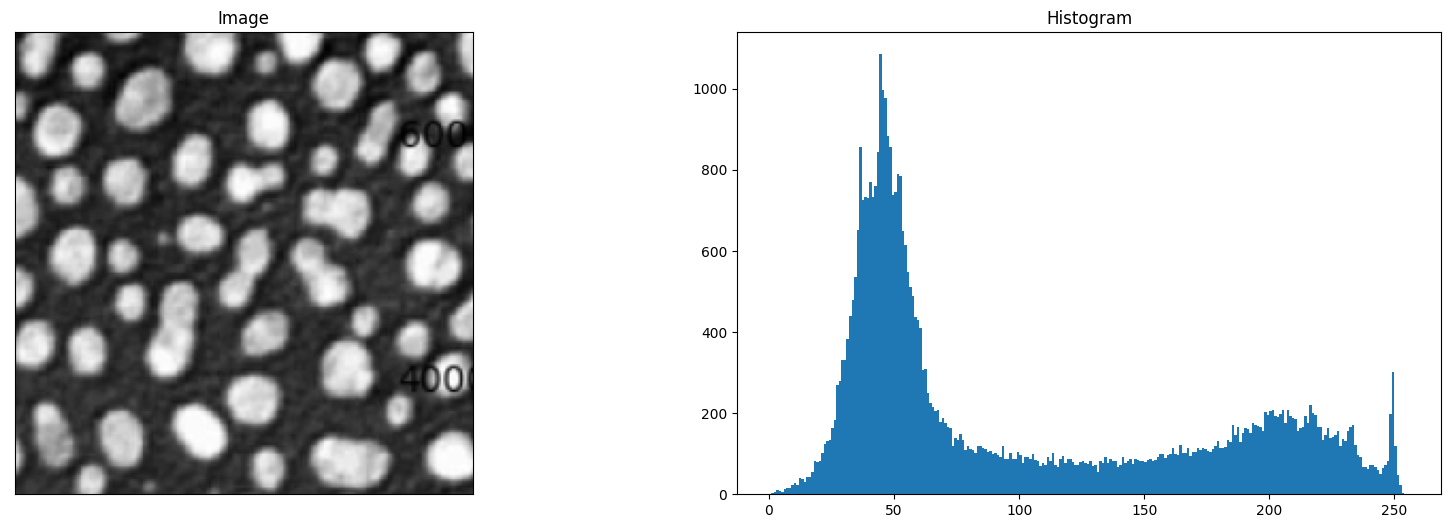

In [547]:
plot_histogram(img)

In [548]:
# k-means
import numpy as np
from sklearn.cluster import KMeans

data = img.flatten()
data = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(data)
kmeans.cluster_centers_

array([[ 53.19446156],
       [193.62967881]])

In [549]:
threshold = kmeans.cluster_centers_.mean()
threshold

123.41207018234147

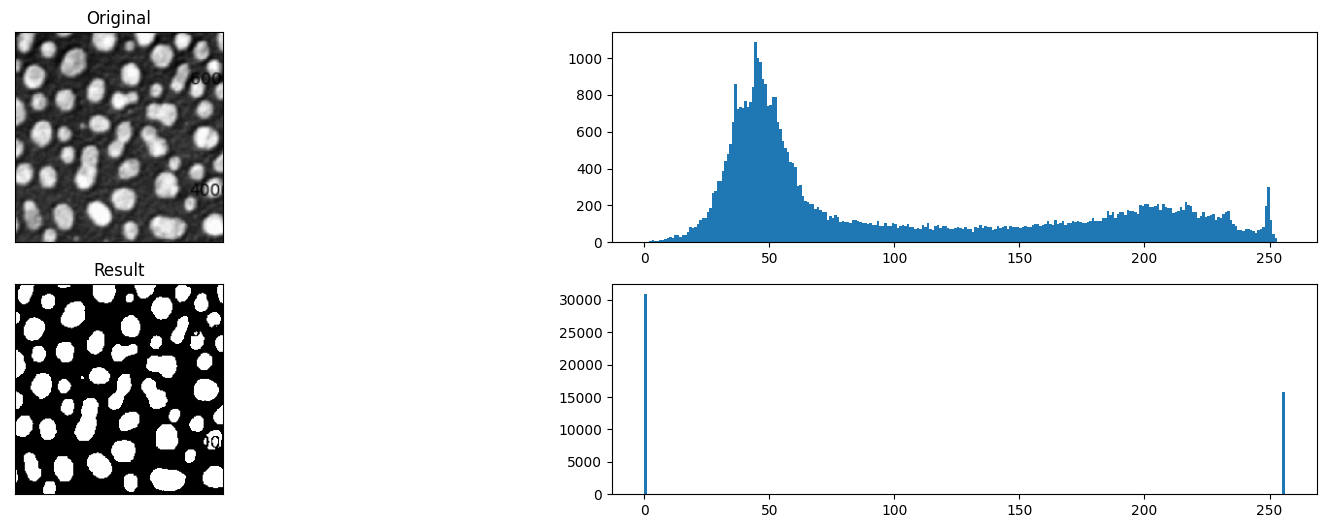

In [550]:
def apply_threshold(im, threshold):
    img = im.copy()
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img
res = apply_threshold(img, threshold)
plot_images(img, res)

In [569]:
data = img.flatten()
data = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(data)
clusters = kmeans.cluster_centers_
clusters = np.sort(clusters.flatten())
print(clusters)
threshold = (clusters[:-1] + clusters[1:]) / 2
print(threshold)
print(kmeans.labels_)

[ 47.28314233 127.68098511 208.43363863]
[ 87.48206372 168.05731187]
[2 2 2 ... 2 2 2]


In [567]:
def apply_threshold_2(im, threshold):
    img = im.copy()
    img[img < threshold[0]] = 0
    mask = (img >= threshold[0]) & (img < threshold[1])
    img[mask] = 122
    img[img >= threshold[1]] = 255
    return img

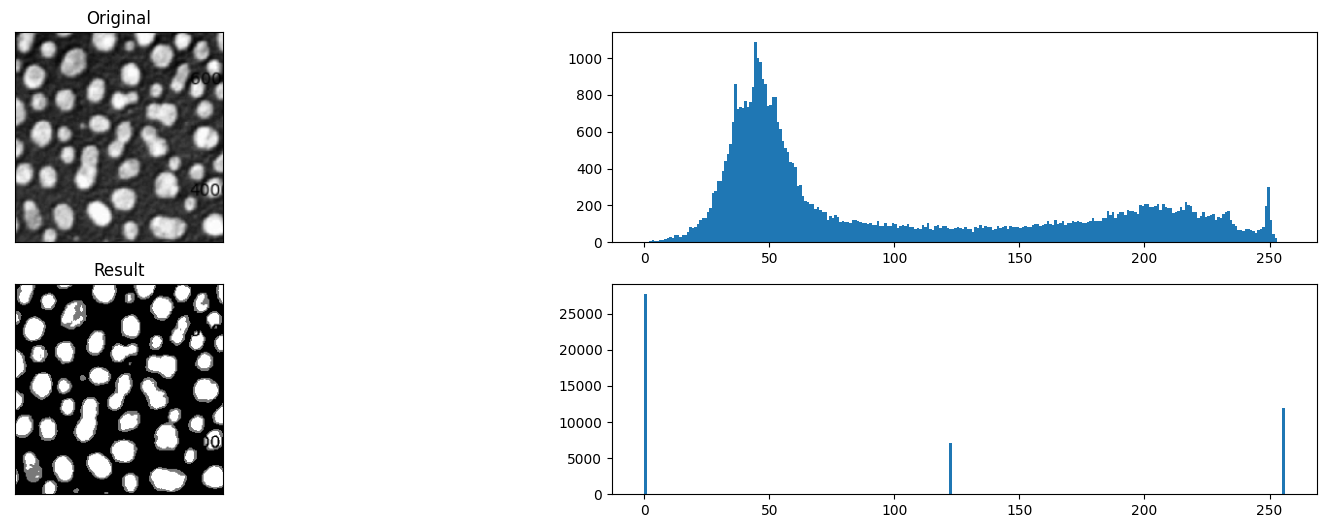

In [568]:
res = apply_threshold_2(img, threshold)
plot_images(img, res)